In [21]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

seaborn.set_style('whitegrid')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    

## Load Data
1. Time: Number of seconds elapsed between this transaction and the first transaction in the database
2. V1-V28: the result of a PCA on user identities and features
3. Amount: transaction amount
4. Class: label (1 for fraudulent transactions, 0 otherwise)

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
byClass = df.groupby(['Class'])['Time'].count()
byClass

Class
0    284315
1       492
Name: Time, dtype: int64

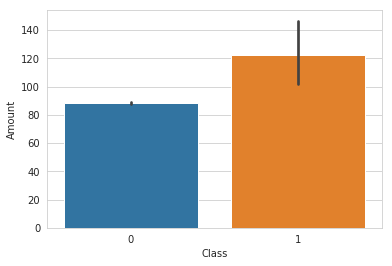

In [4]:
seaborn.barplot(x='Class', y='Amount', data=df)

### Class imbalance

In [14]:
df = pd.read_csv('creditcard_sampledata.csv')
occ = df['Class'].value_counts()
occ

0    284315
1       492
Name: Class, dtype: int64

In [6]:
#ratio of fraud cases
occ[1]/len(df.index)

0.002125

In [7]:
X = df.iloc[:,1:-1].values
X

array([[ 6.40000000e+01,  1.21251089e+00, -9.90542956e-02, ...,
         2.03701457e-02,  1.70370864e-02,  3.47000000e+01],
       [ 6.40000000e+01, -6.58304934e-01,  4.06790567e-01, ...,
        -9.41921698e-02, -9.24931304e-02,  5.49900000e+01],
       [ 1.24000000e+02,  1.10525345e+00,  5.41842002e-01, ...,
         2.07990323e-04,  2.61670473e-02,  6.24000000e+00],
       ...,
       [ 1.72617000e+05,  2.03800082e+00, -8.90420927e-02, ...,
        -1.41401669e-01, -6.74954586e-02,  6.63000000e+01],
       [ 1.72726000e+05, -4.84304342e-01,  3.56726728e-02, ...,
         1.92512319e-02,  2.33020290e-01,  6.80000000e+01],
       [ 1.72766000e+05,  1.97517827e+00, -6.16244014e-01, ...,
         1.41508720e-02, -6.65416968e-02,  2.50000000e+01]])

In [8]:
#labels
y = df.iloc[:,-1].values
y

array([0, 0, 0, ..., 0, 0, 0])

### Feature Selection

In [15]:
features = ['Amount'] + ['V%d' % number for number in range(1, 29)]
features

target = 'Class'

# Build Train set and Test set

X = df[features]
y = df[target]

### Increasing successful detections using data resampling

In [16]:
#method = RandomOverSampler()
method = SMOTE(kind='regular')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0) #split the train & test set before resampling
#apply resampling to the training data only
x_resampled, y_resampled = method.fit_sample(X_train, y_train)

In [12]:
# Print the value_counts on the original labels y
print(pd.value_counts(pd.Series(y)))

0    7983
1      17
Name: Class, dtype: int64


In [13]:
# Print the value_counts
print(pd.value_counts(pd.Series(y_resampled)))

1    6389
0    6389
dtype: int64


## Logistic Regression

In [14]:
logRegmodel = LogisticRegression()
logRegmodel.fit(X_train, y_train)
y_pred = logRegmodel.predict(X_test)

### Check the model results

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1594
           1       0.50      0.17      0.25         6

   micro avg       1.00      1.00      1.00      1600
   macro avg       0.75      0.58      0.62      1600
weighted avg       1.00      1.00      1.00      1600



In [16]:
print(confusion_matrix(y_test, y_pred))

[[1593    1]
 [   5    1]]


## Logistic regression combined with SMOTE by using pipeline

from imblearn.pipeline import Pipeline
#Define resampling method and ML model
resampling = SMOTE(kind='borderline2')
model = LogisticRegression()

#Define the pipeline to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

#Fit pipeline onto training set.
#Pipeline can be treated as a single ML model
pipeline.fit(X_train, y_train)
predicted = pipeline.predict(X_test)

## Random Forest

In [17]:
randForModel = RandomForestClassifier(random_state=5)

In [18]:
x_resampled.shape

(12778, 29)

In [19]:
X_test.shape

(1600, 29)

In [20]:
randForModel.fit(x_resampled, y_resampled)
predicted = randForModel.predict(X_test)
predicted

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
print(accuracy_score(predicted, y_test))

0.996875


### Performance evaluation

In [22]:
 #Predict Probabiliries
probs = randForModel.predict_proba(X_test)
probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [23]:
#ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.8200543705562525
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1594
           1       1.00      0.17      0.29         6

   micro avg       1.00      1.00      1.00      1600
   macro avg       1.00      0.58      0.64      1600
weighted avg       1.00      1.00      1.00      1600

[[1594    0]
 [   5    1]]


In [24]:
#average precision and PR curve
average_precision = average_precision_score(y_test, predicted)

In [25]:
#plotting the precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, predicted)

### Adjusting weights

In [26]:
#class_weight:
# 1. balanced: uses the values of y to automatically adjust weights inversely proportional to class frequencies in 
# the input data
# 2. balanced_subsample: Similar as balanced, just the weights are calculated again at each iteration of growing a 
# tree in the random forest. Only applicable for Random Forest Model

#Hyperparameter tuning
adjustedModel = RandomForestClassifier(
    n_estimators=10,
    criterion='gini', #the way the data is split at each node
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    n_jobs=-1,
    class_weight=None
)

#Using Grid Search for hyperparameters tuning
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features':[2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [1, 30, 100, 200, 300, 1000],
    'criterion': ['gini', 'entropy']
}

model = RandomForestClassifier(random_state=5)
grid_search_model = GridSearchCV(estimator = model, param_grid = param_grid, cv=5, n_jobs=-1, scoring='recall')

#Fit the grid search to the data
grid_search_model.fit(x_resampled, y_resampled)
grid_search_model.best_params_

{'criterion': 'gini',
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 30}

In [27]:
def find_best_threshold(thresholds, fpr, tpr):
    """
    find the best threshold from the roc curve. by finding the threshold for the point which is closest to (fpr=0,tpr=1)
    """
    fpr_tpr = pd.DataFrame({'thresholds': thresholds, 'fpr': fpr, 'tpr': tpr})
    fpr_tpr['dist'] = (fpr_tpr['fpr'])**2 + (fpr_tpr['tpr']-1)**2
    return fpr_tpr.ix[fpr_tpr.dist.idxmin(), 'thresholds']


def get_model_results(model, train, test, y_train, y_test):
    probabilities = model.predict_proba(test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    threshold = find_best_threshold(thresholds, fpr, tpr)
    predictions = probabilities>threshold
    plt.figure()
    plt.plot(fpr, tpr, label='test')
    roc_auc = roc_auc_score(y_test, probabilities)
    probabilities = model.predict_proba(train)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, probabilities)
    plt.plot(fpr, tpr, label='train')
    plt.plot([0, 1], [0, 1], 'r--', label='random guess')
    plt.title("area under the ROC curve = {}".format(roc_auc), fontsize=18);
    print(classification_report(y_test, predictions))
    plt.legend()

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1594
           1       0.02      0.67      0.04         6

   micro avg       0.89      0.89      0.89      1600
   macro avg       0.51      0.78      0.49      1600
weighted avg       0.99      0.89      0.94      1600



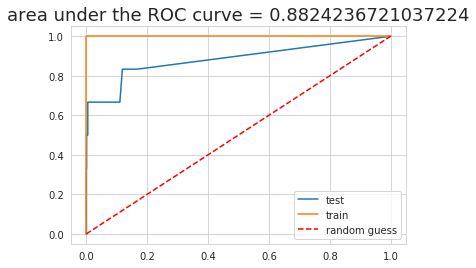

In [28]:
# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12}, criterion='gini',
            n_estimators=30, max_features=2,  min_samples_leaf=3, max_depth=80, n_jobs=-1, random_state=5, min_samples_split=8)
model.fit(x_resampled, y_resampled)
# Get results from your model
get_model_results(model, x_resampled, X_test, y_resampled, y_test)

# Ensemble Method

In [24]:
clf1 = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2',
            min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)
clf3 = DecisionTreeClassifier(random_state=5, class_weight='balanced')

## Adjust weights within the Voting Classifier

In [25]:
#hard: uses the predicted class labels and takes the majority vote
#soft: takes the average probaility by combining the predicted probablities of the individual models
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], 
                                  flatten_transform=True)
ensemble_model.fit(x_resampled, y_resampled)
ensemble_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])